### Noise-free TCNOT

In [15]:
from stabalizer_circuit import StabilizerCircuit

def noise_free_TCNOT():
    sc = StabilizerCircuit(4)

    sc.h(1)
    sc.cx(1, 2)
    sc.cx(0, 1)
    sc.cx(2, 3)
    sc.cx(1, 3)
    sc.cz(2, 0)
    return sc

def extract_storage_qubits(func, qubits = [0,3], shots = 2000):
    rho_storage_qubit_1 = func().tomography_density_matrix(qubits[0], shots=shots)
    rho_storage_qubit_2 = func().tomography_density_matrix(qubits[1], shots=shots)
    return [rho_storage_qubit_1, rho_storage_qubit_2]

noise_free_rhos = extract_storage_qubits(noise_free_TCNOT)
print(noise_free_rhos[0])
print(noise_free_rhos[1])


[[ 1.   +0.j     -0.003-0.0075j]
 [-0.003+0.0075j  0.   +0.j    ]]
[[1.+0.j     0.-0.0025j]
 [0.+0.0025j 0.+0.j    ]]


### Noisy TCNOT

In [21]:
from stabalizer_circuit import StabilizerCircuit

p_bell = 0.02
p_cnot = 0.01
p_meas = 0.05

sc = StabilizerCircuit(4)

sc.h(1)
sc.depolarize1(1, p_bell)

sc.cx(1, 2)
sc.depolarize2(1, 2, p_bell)

sc.cx(0, 1)
sc.depolarize2(0, 1, p_cnot)

sc.cx(2, 3)
sc.depolarize2(2, 3, p_cnot)

# feed-forward via CX with measurement noise on qubit 3
sc.cx(1, 3)
sc.x_error(3, p_meas)

# feed-forward via CZ with measurement noise on qubit 0
sc.cz(2, 0)
sc.z_error(0, p_meas)

noisy_rho_qubit_1 = sc.tomography_density_matrix(0, shots=2000)
noisy_rho_qubit_4 = sc.tomography_density_matrix(3, shots=2000)
print(noisy_rho_qubit_1)
print(noisy_rho_qubit_4)


[[0.9965+0.j    0.    +0.015j]
 [0.    -0.015j 0.0035+0.j   ]]
[[0.936+0.j   0.   -0.01j]
 [0.   +0.01j 0.064+0.j  ]]


### I am trying to get the state vector

In [23]:
import stim
import numpy as np

# Build a small stabilizer circuit
circuit = stim.Circuit("""
    H 0
    CNOT 0 1
""")

# Create a tableau simulator
sim = stim.TableauSimulator()

# Apply the circuit
sim.do_circuit(circuit)

# Get the final state vector (no positional args)
state_vector = sim.state_vector()

# Display result
print("Final statevector:")
print(state_vector)

# Optional: verify normalization
print("Norm:", np.sum(np.abs(state_vector)**2))  # should be 1.0


Final statevector:
[0.70710677+0.j 0.        +0.j 0.        +0.j 0.70710677+0.j]
Norm: 0.99999994


### 1 qubit QEC demo

In [25]:
import stim

def build_713_syndrome_circuit() -> stim.Circuit:
    """Return a Stim circuit implementing the user's 7-qubit code with full
    syndrome extraction on qubits 7–12."""
    c = stim.Circuit()

    # --- Encoding -----------------------------------------------------------
    c.append("H", [4, 5, 6])        # Hadamards on qubits 4-6

    # Fan-out CNOTs (Stim calls them 'CNOT' or alias 'CX')
    c.append("CX", [0, 1])
    c.append("CX", [0, 2])
    c.append("CX", [6, 0])
    c.append("CX", [6, 1])
    c.append("CX", [6, 3])
    c.append("CX", [5, 0])
    c.append("CX", [5, 2])
    c.append("CX", [5, 3])
    c.append("CX", [4, 1])
    c.append("CX", [4, 2])
    c.append("CX", [4, 3])

    # (Optional) place noise here, e.g. c.append("X", [0])

    # --- Bit-flip (X) syndrome extraction -----------------------------------
    c.append("CX", [0, 7])
    c.append("CX", [2, 7])
    c.append("CX", [4, 7])
    c.append("CX", [6, 7])

    c.append("CX", [1, 8])
    c.append("CX", [2, 8])
    c.append("CX", [5, 8])
    c.append("CX", [6, 8])

    c.append("CX", [3, 9])
    c.append("CX", [4, 9])
    c.append("CX", [5, 9])
    c.append("CX", [6, 9])

    # --- Phase-flip (Z) syndrome extraction ---------------------------------
    c.append("H", [10, 11, 12])           # prepare X-basis ancillae

    c.append("CX", [10, 0])
    c.append("CX", [10, 2])
    c.append("CX", [10, 4])
    c.append("CX", [10, 6])

    c.append("CX", [11, 1])
    c.append("CX", [11, 2])
    c.append("CX", [11, 5])
    c.append("CX", [11, 6])

    c.append("CX", [12, 3])
    c.append("CX", [12, 4])
    c.append("CX", [12, 5])
    c.append("CX", [12, 6])

    c.append("H", [10, 11, 12])          

    # --- Measure ancillae ---------------------------------------------------
    c.append("M", [7, 8, 9, 10, 11, 12])  

    return c




In [82]:
import stim
import numpy as np


def encode_713() -> stim.Circuit:
    """Return a Stim circuit implementing the user's 7-qubit code with full
    syndrome extraction on qubits 7–12."""
    c = stim.Circuit()

    # --- Encoding -----------------------------------------------------------
    c.append("H", [1, 2, 3])        # Hadamards on qubits 4-6

    # Fan-out CNOTs (Stim calls them 'CNOT' or alias 'CX')
    c.append("CX", [1, 6])
    c.append("CX", [3, 4])
    c.append("CX", [3, 7])
    c.append("CX", [7, 5])
    c.append("CX", [6, 7])
    c.append("CX", [7, 0])
    c.append("CX", [2, 6])
    c.append("CX", [2, 3])
    c.append("CX", [3, 7])
    c.append("CX", [7, 5])
    c.append("CX", [6, 7])

    return c

def encode_713_v2() -> stim.Circuit:
    """Return a Stim circuit implementing the user's 7-qubit code with full
    syndrome extraction on qubits 7–12."""
    c = stim.Circuit()

    # --- Encoding -----------------------------------------------------------
    c.append("H", [4, 5, 6])        # Hadamards on qubits 4-6

    # Fan-out CNOTs (Stim calls them 'CNOT' or alias 'CX')
    c.append("CX", [0, 1])
    c.append("CX", [0, 2])
    c.append("CX", [6, 0])
    c.append("CX", [6, 1])
    c.append("CX", [6, 3])
    c.append("CX", [5, 0])
    c.append("CX", [5, 2])
    c.append("CX", [5, 3])
    c.append("CX", [4, 1])
    c.append("CX", [4, 2])
    c.append("CX", [4, 3])

    return c

def encode_713_v3() -> stim.Circuit:
    """Return a Stim circuit implementing the user's 7-qubit code with full
    syndrome extraction on qubits 7–12."""
    c = stim.Circuit()

    # --- Encoding -----------------------------------------------------------
    c.append("H", [0, 1, 2])        # Hadamards on qubits 4-6

    # Fan-out CNOTs (Stim calls them 'CNOT' or alias 'CX')
    c.append("CX", [6, 5])
    c.append("CX", [6, 4])
    c.append("CX", [0, 3])
    c.append("CX", [0, 5])
    c.append("CX", [0, 6])
    c.append("CX", [1, 3])
    c.append("CX", [1, 4])
    c.append("CX", [1, 6])
    c.append("CX", [2, 3])
    c.append("CX", [2, 4])
    c.append("CX", [2, 5])

    return c

def partial_trace_last_qubit(state_vector: np.ndarray, num_qubits: int = 8) -> np.ndarray:
    """
    Trace out the last qubit of an n-qubit state vector.
    
    Args:
        state_vector: numpy array of shape (2**n,) representing the pure state.
        num_qubits: total number of qubits n (default 8).
    
    Returns:
        rho_reduced: numpy array of shape (2**(n-1), 2**(n-1)), the reduced density matrix
                     on the first (n-1) qubits after tracing out the last qubit.
    """
    # Ensure the input length matches 2**num_qubits
    dim = 2 ** num_qubits
    if state_vector.size != dim:
        raise ValueError(f"Expected state vector of length {dim}, got {state_vector.size}")
    
    # Reshape to separate the last qubit: shape (2**(n-1), 2)
    psi = state_vector.reshape((2**(num_qubits - 1), 2))
    
    # Compute the reduced density matrix: sum over the last qubit index
    # ρ_reduced[i, i'] = sum_{j=0,1} ψ[i, j] * ψ*[i', j]
    rho_reduced = psi @ psi.conj().T
    
    return rho_reduced


def statevector_to_latex(psi, tol=1e-6):
    """
    Given a length-2^n statevector `psi`, returns a LaTeX string of the form
      \\frac{1}{\\sqrt{m}} (|b1...bn> + ... )
    where m = number of nonzero amplitudes and the basis states are sorted by index.
    """
    # 1) Find indices with significant amplitude
    inds = np.nonzero(np.abs(psi) > tol)[0]
    amps = psi[inds]

    # 2) Verify all nonzero amplitudes are (approximately) equal
    if not np.allclose(amps, amps[0], atol=tol):
        raise ValueError("Amplitudes are not all equal; cannot factor out a common prefactor.")

    m = len(inds)                       # number of terms
    n = int(np.log2(psi.size))         # number of qubits
    pre = rf"\frac{{1}}{{\sqrt{{{m}}}}}"  # e.g. \frac{1}{\sqrt{8}}

    # 3) Build the sum of basis kets
    terms = []
    for idx in inds:
        bits = format(idx, f"0{n}b")
        terms.append(rf"|{bits}⟩")
    body = " + ".join(terms)

    return pre + r"\bigl(" + body + r"\bigr)"



In [83]:
c = encode_713_v3()

sim = stim.TableauSimulator()
sim.do_circuit(c)

psi = sim.state_vector()
latex_str = statevector_to_latex(psi)
# partial_trace_last_qubit(psi)
print(latex_str)

\frac{1}{\sqrt{8}}\bigl(|0000000⟩ + |0001111⟩ + |0110011⟩ + |0111100⟩ + |1010101⟩ + |1011010⟩ + |1100110⟩ + |1101001⟩\bigr)


In [79]:
import numpy as np
import stim

# --- Method 1: Manual Basis State Superposition ---

# 1) Define the 8 basis indices for |0>_L (Steane Code)
indices = [
    0b0000000,
    0b1111000,
    0b0110110,
    0b0011011,
    0b1001110,
    0b1010101,
    0b0101101,
    0b1100011,
]

# 2) Build the state vector ψ2 of length 2^7 = 128
psi2 = np.zeros(2**7, dtype=complex)
for i in indices:
    psi2[i] = 1
psi2 /= np.linalg.norm(psi2)  # normalize: each amplitude = 1/√8

# 3) Print nonzero components of ψ2
print("🔹 Nonzero components of ψ2 (manual construction):")
for i, amp in enumerate(psi2):
    if np.abs(amp) > 1e-10:
        print(f"  |{format(i, '07b')}⟩ : {amp:.5f}")
print()

# --- Method 2: Stim Circuit Construction ---

def steane_logical_zero_circuit() -> stim.Circuit:
    c = stim.Circuit()
    c.append_operation("H", [0])
    c.append_operation("H", [1])
    c.append_operation("H", [2])
    c.append_operation("CX", [0, 3])
    c.append_operation("CX", [1, 3])
    c.append_operation("CX", [0, 5])
    c.append_operation("CX", [1, 6])
    c.append_operation("CX", [2, 4])
    c.append_operation("CX", [2, 6])
    c.append_operation("CX", [3, 4])
    c.append_operation("CX", [5, 6])
    return c

# Simulate the circuit
circuit = steane_logical_zero_circuit()
sim = stim.TableauSimulator()
sim.do_circuit(circuit)
psi1 = sim.state_vector()

# Print nonzero components of ψ1
print("🔹 Nonzero components of ψ1 (Stim circuit):")
for i, amp in enumerate(psi1):
    if np.abs(amp) > 1e-10:
        print(f"  |{format(i, '07b')}⟩ : {amp:.5f}")
print()

# --- Comparison ---

# 1. Print vector lengths
print(f"✅ Vector lengths: ψ1 = {len(psi1)}, ψ2 = {len(psi2)}")

# 2. Compute inner product and fidelity
inner_product = np.vdot(psi1, psi2)
fidelity = np.abs(inner_product)**2
print(f"✅ Inner product ⟨ψ1|ψ2⟩ = {inner_product:.5f}")
print(f"✅ Fidelity = |⟨ψ1|ψ2⟩|^2 = {fidelity:.5f}")

# 3. Check maximum absolute difference
max_diff = np.max(np.abs(psi1 - psi2))
print(f"✅ Max amplitude difference: {max_diff:.2e}")


🔹 Nonzero components of ψ2 (manual construction):
  |0000000⟩ : 0.35355+0.00000j
  |0011011⟩ : 0.35355+0.00000j
  |0101101⟩ : 0.35355+0.00000j
  |0110110⟩ : 0.35355+0.00000j
  |1001110⟩ : 0.35355+0.00000j
  |1010101⟩ : 0.35355+0.00000j
  |1100011⟩ : 0.35355+0.00000j
  |1111000⟩ : 0.35355+0.00000j

🔹 Nonzero components of ψ1 (Stim circuit):
  |0000000⟩ : 0.35355+0.00000j
  |0001110⟩ : 0.35355+0.00000j
  |0100011⟩ : 0.35355+0.00000j
  |0101101⟩ : 0.35355+0.00000j
  |1010100⟩ : 0.35355+0.00000j
  |1011010⟩ : 0.35355+0.00000j
  |1110111⟩ : 0.35355+0.00000j
  |1111001⟩ : 0.35355+0.00000j

✅ Vector lengths: ψ1 = 128, ψ2 = 128
✅ Inner product ⟨ψ1|ψ2⟩ = 0.25000+0.00000j
✅ Fidelity = |⟨ψ1|ψ2⟩|^2 = 0.06250
✅ Max amplitude difference: 3.54e-01


State vector length: 128
State vector:
[0.35355+0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.35355+0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.35355+0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.35355+0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +

In [78]:
print (psi1)
print (psi2)

[0.35355+0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.35355+0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.35355+0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.35355+0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j 0.     +0.j
 0.     +0.j 0.     +0.j 0.     +0.

In [83]:
from stabalizer_circuit import StabilizerCircuit


sc = StabilizerCircuit(13)

################ Encoding:
i = 0

sc.h(i+4)
sc.h(i+5)
sc.h(i+6)
sc.cx(i,i+1)
sc.cx(i,i+2)
sc.cx(i+6,i)
sc.cx(i+6,i+1)
sc.cx(i+6,i+3)
sc.cx(i+5,i)
sc.cx(i+5,i+2)
sc.cx(i+5,i+3)
sc.cx(i+4,i+1)
sc.cx(i+4,i+2)
sc.cx(i+4,i+3)
i += 13

## Simulate Noise

# sc.x(0)


############### Decoding
i = 0

# Bit flip detection
sc.cx(i,i+7)
sc.cx(i+2,i+7)
sc.cx(i+4,i+7)
sc.cx(i+6,i+7)
sc.cx(i+1,i+8)
sc.cx(i+2,i+8)
sc.cx(i+5,i+8)
sc.cx(i+6,i+8)
sc.cx(i+3,i+9)
sc.cx(i+4,i+9)
sc.cx(i+5,i+9)
sc.cx(i+6,i+9)

# Phase flip detection 
sc.h(i+10)
sc.h(i+11)
sc.h(i+12)
sc.cx(i+10,i)
sc.cx(i+10,i+2)
sc.cx(i+10,i+4)
sc.cx(i+10,i+6)
sc.cx(i+11,i+1)
sc.cx(i+11,i+2)
sc.cx(i+11,i+5)
sc.cx(i+11,i+6)
sc.cx(i+12,i+3)
sc.cx(i+12,i+4)
sc.cx(i+12,i+5)
sc.cx(i+12,i+6)
sc.h(i+10)
sc.h(i+11)
sc.h(i+12)

# Measurement
sc.measure(i+7)
sc.measure(i+8)
sc.measure(i+9)
sc.measure(i+10)
sc.measure(i+11)
sc.measure(i+12)

qec_rho = sc.tomography_density_matrix(0, shots=2000)
print(qec_rho)

[[1. +0.j  0.5-0.5j]
 [0.5+0.5j 0. +0.j ]]


### Noiseless TCNOT with QEC (base case)

In [66]:
from stabalizer_circuit import StabilizerCircuit


sc = StabilizerCircuit(52)

S1 = 0
C1 = 13
C2 = 26
S2 = 39

# Encoding:
i = 0
while i < 52:
    sc.h(i+4)
    sc.h(i+5)
    sc.h(i+6)
    sc.cx(i,i+1)
    sc.cx(i,i+2)
    sc.cx(i+6,i)
    sc.cx(i+6,i+1)
    sc.cx(i+6,i+3)
    sc.cx(i+5,i)
    sc.cx(i+5,i+2)
    sc.cx(i+5,i+3)
    sc.cx(i+4,i+1)
    sc.cx(i+4,i+2)
    sc.cx(i+4,i+3)
    i += 13


sc.h(C1)
sc.cx(C1, C2)
sc.cx(S1, C1)
sc.cx(C2, S2)
sc.cx(C1, S2)
sc.cz(C2, S1)

## Decoding
i = 0
while i < 52:

    # Bit flip detection
    sc.cx(i,i+7)
    sc.cx(i+2,i+7)
    sc.cx(i+4,i+7)
    sc.cx(i+6,i+7)
    sc.cx(i+1,i+8)
    sc.cx(i+2,i+8)
    sc.cx(i+5,i+8)
    sc.cx(i+6,i+8)
    sc.cx(i+3,i+9)
    sc.cx(i+4,i+9)
    sc.cx(i+5,i+9)
    sc.cx(i+6,i+9)

    # Phase flip detection 
    sc.h(i+10)
    sc.h(i+11)
    sc.h(i+12)
    sc.cx(i+10,i)
    sc.cx(i+10,i+2)
    sc.cx(i+10,i+4)
    sc.cx(i+10,i+6)
    sc.cx(i+11,i+1)
    sc.cx(i+11,i+2)
    sc.cx(i+11,i+5)
    sc.cx(i+11,i+6)
    sc.cx(i+12,i+3)
    sc.cx(i+12,i+4)
    sc.cx(i+12,i+5)
    sc.cx(i+12,i+6)
    sc.h(i+10)
    sc.h(i+11)
    sc.h(i+12)

    # Measurement
    sc.measure(i+7)
    sc.measure(i+8)
    sc.measure(i+9)
    sc.measure(i+10)
    sc.measure(i+11)
    sc.measure(i+12)

    i += 13


noiseless_qec_rho_qubit_1 = sc.tomography_density_matrix(S1, shots=2000)
noiseless_qec_rho_qubit_4 = sc.tomography_density_matrix(S2, shots=2000)
print(noiseless_qec_rho_qubit_1)
print(noiseless_qec_rho_qubit_4)


[[1. +0.j  0.5-0.5j]
 [0.5+0.5j 0. +0.j ]]
[[1. +0.j  0.5-0.5j]
 [0.5+0.5j 0. +0.j ]]


### Single Qubit [[7,1,3]] QEC from Harvard Paper

In [30]:
from stabalizer_circuit import StabilizerCircuit

sc = StabilizerCircuit(13)

# Encoding Circuit

i = 0

sc.h(i+4)
sc.h(i+5)
sc.h(i+6)
sc.cx(i,i+1)
sc.cx(i,i+2)
sc.cx(i+6,i)
sc.cx(i+6,i+1)
sc.cx(i+6,i+3)
sc.cx(i+5,i)
sc.cx(i+5,i+2)
sc.cx(i+5,i+3)
sc.cx(i+4,i+1)
sc.cx(i+4,i+2)
sc.cx(i+4,i+3)

# Error
# sc.x(i)

# Decoding Circuit
for j in range(7,13):
    sc.h(i+j)
sc.cx(i+7,i)
sc.cx(i+7,i+4)
sc.cx(i+8,i+1)
sc.cx(i+8,i+4)
sc.cx(i+9,i+2)
sc.cx(i+9,i+5)
sc.cx(i+10,i+3)
sc.cx(i+10,i+6)
sc.cz(i+11,i+2)
sc.cz(i+11,i+3)
sc.cy(i+11,i+5)
sc.cy(i+11,i+6)
sc.cz(i+12, i)
sc.cz(i+12,i+2)
sc.cx(i+12, i+3)
sc.cz(i+12,i+1)
sc.cz(i+12,i+4)
sc.cz(i+12,i+5)
for j in range(7,13):
    sc.measure(i+j)

# Print Measurement Results
rho, shot = sc.tomography_density_matrix(qubit=0, shots=2000)
print("ρ =", rho)
print("single-shot outcomes:", shot)   



ρ = [[ 0.5015+0.j     -0.0165+0.0015j]
 [-0.0165-0.0015j  0.4985+0.j    ]]
single-shot outcomes: {'Z': 0, 'X': 1, 'Y': 0}


In [2]:
from stabalizer_circuit import StabilizerCircuit

sc = StabilizerCircuit(13)

# Encoding Circuit

i = 0

sc.h(i+4)
sc.h(i+5)
sc.h(i+6)
sc.cx(i,i+1)
sc.cx(i,i+2)
sc.cx(i+6,i)
sc.cx(i+6,i+1)
sc.cx(i+6,i+3)
sc.cx(i+5,i)
sc.cx(i+5,i+2)
sc.cx(i+5,i+3)
sc.cx(i+4,i+1)
sc.cx(i+4,i+2)
sc.cx(i+4,i+3)

# Error
# sc.x(i)

# Decoding Circuit
for j in range(7,13):
    sc.h(i+j)
sc.cx(i+7,i)
sc.cx(i+7,i+4)
sc.cx(i+8,i+1)
sc.cx(i+8,i+4)
sc.cx(i+9,i+2)
sc.cx(i+9,i+5)
sc.cx(i+10,i+3)
sc.cx(i+10,i+6)
sc.cz(i+11,i+2)
sc.cz(i+11,i+3)
sc.cy(i+11,i+5)
sc.cy(i+11,i+6)
sc.cz(i+12, i)
sc.cz(i+12,i+2)
sc.cx(i+12, i+3)
sc.cz(i+12,i+1)
sc.cz(i+12,i+4)
sc.cz(i+12,i+5)
for j in range(7,13):
    sc.measure(i+j)

# Print Measurement Results
rho = sc.tomography_density_matrix(qubit=0, shots=2000)
print("ρ =", rho)



ρ = [[0.4865+0.j    0.009 -0.019j]
 [0.009 +0.019j 0.5135+0.j   ]]


In [4]:
from stabalizer_circuit import StabilizerCircuit
import numpy as np

sc = StabilizerCircuit(1)
sc.h(0)
rho_est = sc.tomography_density_matrix(0, shots=2000)
print(rho_est)

[[0.5055+0.j    0.5   -0.015j]
 [0.5   +0.015j 0.4945+0.j   ]]


### Noisy TCNOT with QEC

In [67]:
from stabalizer_circuit import StabilizerCircuit

p_bell = 0.02
p_cnot = 0.01
p_meas = 0.05

sc = StabilizerCircuit(52)

S1 = 0
C1 = 13
C2 = 26
S2 = 39

# Encoding:
i = 0
while i < 52:
    sc.h(i+4)
    sc.h(i+5)
    sc.h(i+6)
    sc.cx(i,i+1)
    sc.cx(i,i+2)
    sc.cx(i+6,i)
    sc.cx(i+6,i+1)
    sc.cx(i+6,i+3)
    sc.cx(i+5,i)
    sc.cx(i+5,i+2)
    sc.cx(i+5,i+3)
    sc.cx(i+4,i+1)
    sc.cx(i+4,i+2)
    sc.cx(i+4,i+3)
    i += 13


sc.h(C1)
sc.depolarize1(C1, p_bell)

sc.cx(C1, C2)
sc.depolarize2(C1, C2, p_bell)

sc.cx(S1, C1)
sc.depolarize2(S1, C1, p_cnot)

sc.cx(C2, S2)
sc.depolarize2(C2, S2, p_cnot)

# feed-forward via CX with measurement noise on qubit 3
sc.cx(C1, S2)
sc.x_error(S2, p_meas)

# feed-forward via CZ with measurement noise on qubit 0
sc.cz(C2, S1)
sc.z_error(S1, p_meas)


## Decoding
i = 0
while i < 52:

    # Bit flip detection
    sc.cx(i,i+7)
    sc.cx(i+2,i+7)
    sc.cx(i+4,i+7)
    sc.cx(i+6,i+7)
    sc.cx(i+1,i+8)
    sc.cx(i+2,i+8)
    sc.cx(i+5,i+8)
    sc.cx(i+6,i+8)
    sc.cx(i+3,i+9)
    sc.cx(i+4,i+9)
    sc.cx(i+5,i+9)
    sc.cx(i+6,i+9)

    # Phase flip detection 
    sc.h(i+10)
    sc.h(i+11)
    sc.h(i+12)
    sc.cx(i+10,i)
    sc.cx(i+10,i+2)
    sc.cx(i+10,i+4)
    sc.cx(i+10,i+6)
    sc.cx(i+11,i+1)
    sc.cx(i+11,i+2)
    sc.cx(i+11,i+5)
    sc.cx(i+11,i+6)
    sc.cx(i+12,i+3)
    sc.cx(i+12,i+4)
    sc.cx(i+12,i+5)
    sc.cx(i+12,i+6)
    sc.h(i+10)
    sc.h(i+11)
    sc.h(i+12)

    # Measurement
    sc.measure(i+7)
    sc.measure(i+8)
    sc.measure(i+9)
    sc.measure(i+10)
    sc.measure(i+11)
    sc.measure(i+12)

    i += 13



qec_rho_qubit_1 = sc.tomography_density_matrix(S1, shots=2000)
qec_rho_qubit_4 = sc.tomography_density_matrix(S2, shots=2000)
print(qec_rho_qubit_1)
print(qec_rho_qubit_4)


[[0.996 +0.j     0.4925-0.4945j]
 [0.4925+0.4945j 0.004 +0.j    ]]
[[0.993+0.j     0.494-0.4955j]
 [0.494+0.4955j 0.007+0.j    ]]


### Comparison heatmap

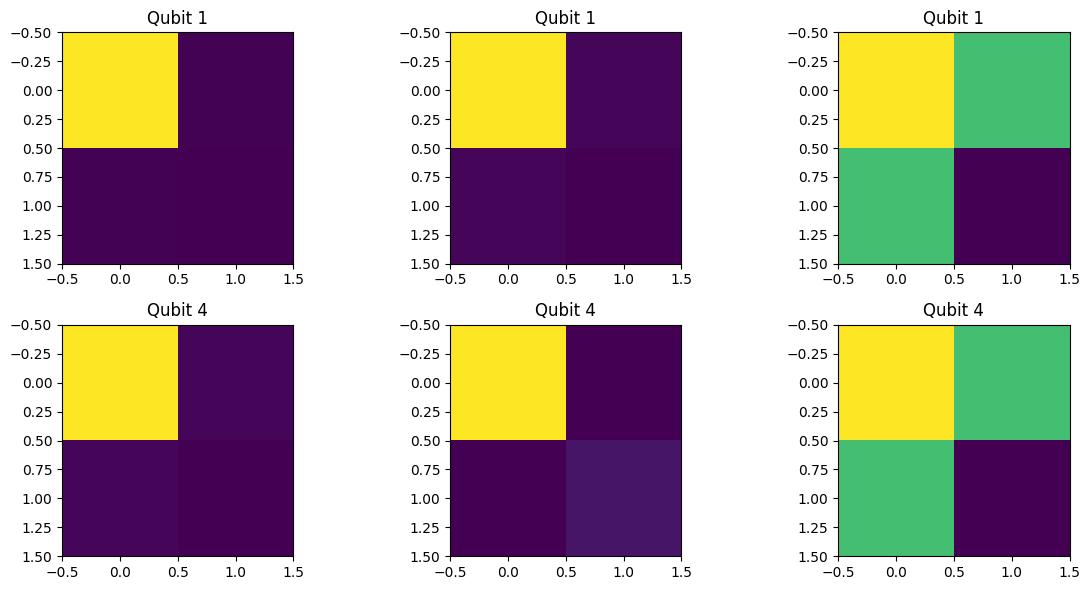

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute values for visualization
abs_dms_1 = [np.abs(dm) for dm in (noise_free_rhos[0],
                                   noisy_rho_qubit_1,
                                   qec_rho_qubit_1)]
abs_dms_4 = [np.abs(dm) for dm in (noise_free_rhos[1],
                                   noisy_rho_qubit_4,
                                   qec_rho_qubit_4)]

# Create a 2×3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes[0]):
    im = ax.imshow(abs_dms_1[i], interpolation='nearest')
    ax.set_title(f'Qubit 1')

for i, ax in enumerate(axes[1]):
    im = ax.imshow(abs_dms_4[i], interpolation='nearest')
    ax.set_title(f'Qubit 4')

# One shared colorbar
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
# cbar.set_label('│element│')

plt.tight_layout()
plt.show()


C:\Users\PatEliteBook\AppData\Local\Temp\ipykernel_39980\991523789.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


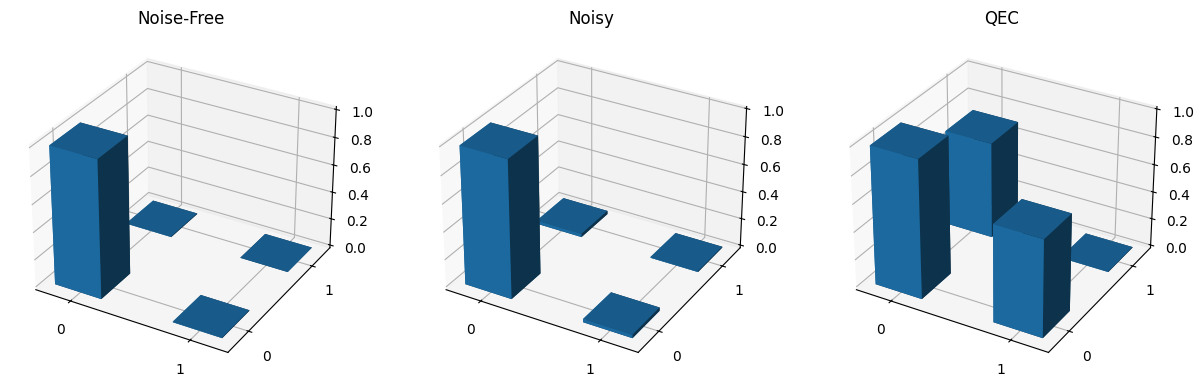

In [69]:
import numpy as np
import matplotlib.pyplot as plt

dms = [
    np.abs(noise_free_rhos[0]),
    np.abs(noisy_rho_qubit_1),
    np.abs(qec_rho_qubit_1),
]
titles = ["Noise-Free", "Noisy", "QEC"]

fig = plt.figure(figsize=(15, 5))
for i, dm in enumerate(dms, start=1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    xpos = np.array([0, 1, 0, 1])
    ypos = np.array([0, 0, 1, 1])
    zpos = np.zeros(4)
    dx = dy = 0.4
    dz = dm.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
    ax.set_xticks([0.2, 1.2])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticks([0.2, 1.2])
    ax.set_yticklabels(["0", "1"])
    ax.set_title(titles[i - 1])

plt.tight_layout()
plt.show()
